# Sheet 12 - Numerical Part
To be handed in until July 17th, 18:00. Please send your solutions to pascal.weckesser@physik.uni-freiburg.de.

In [409]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import qutip as q
pi = np.pi

from IPython.core.display import SVG 

$$\newcommand{\bra}[1]{\left\langle\,{#1}\,\right|}
\newcommand{\ket}[1]{\left|\,{#1}\,\right\rangle}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
# Spin Flip Correction

`qutip` has the ability to compute the effect of multi-qubit gates of general input states and give a latex representation of the algorithm. This can look like this:

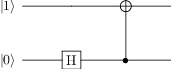

In [410]:
qc = q.QubitCircuit(N=2)

# input states defined here are only used for plotting!
qc.add_state('0', [0])
qc.add_state('1', [1])

# add a Hadamard / SNOT gate for qubit 0. Pay attention, the counting starts from the
# most significant (= first in terms of binary represenation) bit.
qc.add_gate('SNOT', controls=None, targets=0)

# entangle the two qubits
qc.add_gate('CNOT', controls=0, targets=1)

# this allows us to create a neat representation of the algorithm
qc.png

*Remark:* `qc.png` is possibly not working due to [this bug](https://bugs.launchpad.net/ubuntu/+source/imagemagick/+bug/1796563). However a `.pdf` should be created if you have latex installed.

The effect of the gate on a state can be computed as in the following example:

In [411]:
# sorry for the redundance here
def five_bit_basis_representation(ket):
    for i, s in enumerate(ket):
        print('|{0:05b}> : {1:.3f}'.format(i, s[0,0]))
        
def three_bit_basis_representation(ket):
    for i, s in enumerate(ket):
        print('|{0:03b}> : {1:.3f}'.format(i, s[0,0]))
        
def two_bit_basis_representation(ket):
    for i, s in enumerate(ket):
        print('|{0:02b}> : {1:.3f}'.format(i, s[0,0]))

In [412]:
# create a matrix that represents the total effect of the operation
gate_operation = q.gate_sequence_product(qc.propagators())

# let it act on the state |01>
psi = q.ket('01')
psi_f = gate_operation * psi

# investigate the gate action in the "bit string ordered" basis, we see
# that we created the fully entangled state |+>
two_bit_basis_representation(psi_f)

|00> : 0.000+0.000j
|01> : 0.707+0.000j
|10> : 0.707+0.000j
|11> : 0.000+0.000j


In the lecture you have learned about a simple quantum error correction scheme. It consists of a signal qubit (0) that should be uncorrupted and two *ancilla* qubits (1,2). By measuring the qubits 1 and 2 one can determine, whether there has been a spin flip ($\pi$-rotation around $x$) on any of the three qubits, without collapsing qubit 0. Therefore one can correct the system for possible changes by applying a followup gate.


**a)** *(5 Points)* Implement the error correction scheme as a `QubitCircuit` and verify the three predicted outcomes, depending on which qubit undergoes a spin-flip, as well as that the quantum information of the signal qubit is conserved. Visualize the gate sequence (no penalty if it doesn't work due to software bugs).

# Deutsch-Josza Algorithm

The Deutsch-Josza algorithm is an example for a (somewhat constructed) problem in which a quantum computer outperforms a classical computer. The problem is stated as follows: consider a Boolean function
\begin{align*}
f(\lbrace 0, 1 \rbrace^n) \longrightarrow \lbrace 0, 1 \rbrace
\end{align*}
mapping $n$ (qu)bits of input to a single (qu)bit of output. We are promised that the function $f(x)$ is either a constant or a balanced [1] function and want to find out which of both possibilities is realized. Classically, to determine the nature of the function, we would need to check more than half of the possible inputs, i.e. $(2^n +1)/2$, to be sure. Using the Deutsch-Josza algorithm, the computational effort consists of only a single evaluation of $f(x)$ and the measurement of $n-1$ qubits, thus scaling linearly instead of exponentially with $n$.

[1] A balanced function maps the input to an output of 50\% each $0$ and $1$.

The implementation of the Deutsch-Josza algorithm is shown below. $n$ input qubits are initialized in the $\ket{0}$ state, one target qubit is initialized in the state $\ket{1}$. The data qubits then subject to a Hadamard transform $H_n = H \otimes ... \otimes H$, the same is done for the target qubit. The circuits kernel $U_f$ ouputs the unvaried data qubits and subjects $\ket{y}$ to the operation $\ket{y \oplus f(x)}$. You might remember from the last paper that $\oplus$ equals a controled-NOT operation, here $\ket{f(x)}$ is the control and $\ket{y}$ is the target qubit. After the kernel, the data qubits again undergo a Hadamard transform and are then measured.

The nature of $f(x)$ is determined in the following way: if the function is constant, the measurement outcome will be $\ket{0}^n$ with probability $1$, if it is balanced there will be $0$ probability of measuring the final state $\ket{0}^n$

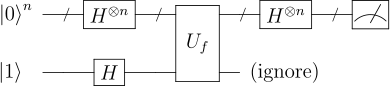

In [415]:
SVG('qc_intro_deutsch_josza.svg')

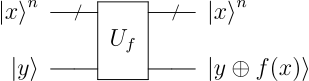

In [416]:
SVG('qc_intro_deutsch_josza1.svg')

**a)** *(5 Points)* Below, you are given two examplary circuit kernel for a constant/balanced $f(x)$. Implement the Deutsch-Josza algorithm on five qubits and verify the described outcome for both kernels.

*Implementation:* I recommend you to multiply single gate operations from `qutip.gates` to your  initial state vector `qutip.ket('10000')`. The Hadamard gate is implemented in `qutip.gates.snot(N, target)`, the Hadamard transform is `qutip.hadamard_transform(N)`.

In [417]:
def unary_constant(ket_input, N=2):
    # in the constant case we can choose f(x) = 0 or 1
    fx = 1
    
    # for 1 the operation |y + f(x)> is equivalent to a NOT operation
    # for 0, the operation is equal to unity
    if fx == 1:
        gate = q.gates.sqrtnot(N=N, target=0)**2
    elif fx ==0:
        gate = q.tensor([q.qeye(2)]*N)
    
    ket_output = gate * ket_input
    
    return ket_output

def unary_balanced(ket_input, N=2):
    # as an exemplary unary balanced function we use one, whose
    # output is 0 for bit N == 0 and 1 for bit N == 1
    # this means, the operation is a CNOT with control N and target 0
    cnot = q.gates.cnot(N=N, control=N-1, target=0)
    ket_output = cnot * ket_input
    
    return ket_output

**b)** *(2 Points)* Describe where the speedup of the Deutsch-Josza algorithm originates.